# Search Depth

This notebook introduces search-depth: important concept for validating multiclass classification problems. Building predictive models for multi-class classification problems leads to a tricky model fit assessment task. 

In this notebook we will:
- Show how to use search-depth to compare model fits
- Demonstrate how to build a posterior re-weighted `MixtureDistribution` in `dmx-learn`

We'll demonstrate search depth using a synthetic cybersecurity dataset with:
- **User authentication data**: failed logins, session times, process IDs
- **300 users** with varying behavioral patterns

We'll compare three approaches:
1. **Random Forest** - Standard discriminative classifier
2. **K-Nearest Neighbors (KNN)** - Instance-based learning
3. **DMX Mixture Model** - Probabilistic generative approach

By the end, you'll see how mixture models can dramatically reduce search depth compared to traditional methods.

In [ ]:
import os
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier

from numpy.random import RandomState
from dmx.stats import * 
from dmx.utils.estimation import optimize

import re
import matplotlib.pyplot as plt


DATA_PATH = "../data/search_depth"
TRAIN_DATA = os.path.join(DATA_PATH, "search_depth_train_data.csv")
TEST_DATA = os.path.join(DATA_PATH, "search_depth_test_data.csv")

# EDA
Lets load in the data and begin an EDA. We will define a function `extract_id` to help parse string ids in this notebook.

In [160]:
def extract_id(x: str) -> int:
    """Extract the numeric ID from a string formatted as 'prefix_<number>'.
    
    Args:
        x: String containing a numeric ID (e.g., 'user_42', 'process_17')

    """
    return int(re.search(r'\d+', x).group())

In [161]:
# Read in the training and test data
train_df = pd.read_csv(TRAIN_DATA)
test_df = pd.read_csv(TEST_DATA)

Let's peak at the data and see what is looks like...

In [162]:
train_df.head()

,user_id,failed_logins,session_time,process_id
0,user_0,12,457,process_39
1,user_0,12,491,process_12
2,user_0,12,564,process_33
3,user_0,9,463,process_30
4,user_1,0,992,process_22


So we have target variable `user_id` and features `failed_logins` (int), `session_time` (float), and `process_id` (str). Let's dig into the data and see if we can build a model to classify `user_id` based on the features. 

In [163]:
# Basic info
num_users = train_df["user_id"].nunique()
num_procs = train_df["process_id"].nunique()

print(f"Number of training samples: {len(train_df)}.")
print(f"Number of users: {num_users}.")
print(f"Number of process ids: {num_procs}.")

Number of training samples: 1100.
Number of users: 300.
Number of process ids: 50.


It looks like there are 300 users. We can plot the number of observations per user to get an idea of how many samples per user we have in our training set. 

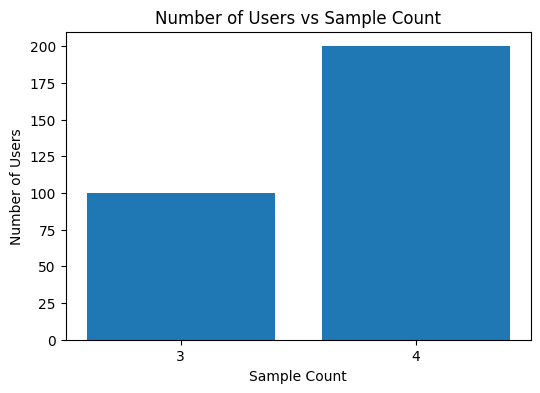

In [164]:
# Count the number of samples per user
user_counts = train_df['user_id'].value_counts()

# Count how many users have each sample count
count_of_counts = user_counts.value_counts().sort_index()

plt.figure(figsize=(6,4))
plt.bar(count_of_counts.index, count_of_counts.values)
plt.xlabel('Sample Count')
plt.ylabel('Number of Users')
plt.title('Number of Users vs Sample Count')
plt.xticks(count_of_counts.index)
plt.show()

Every user has either 3 or 4 samples, so we have some repition, but not too much per user. Let's take a look at the distribution of failed logins per user and session times. They both look like they have 3-peaks.

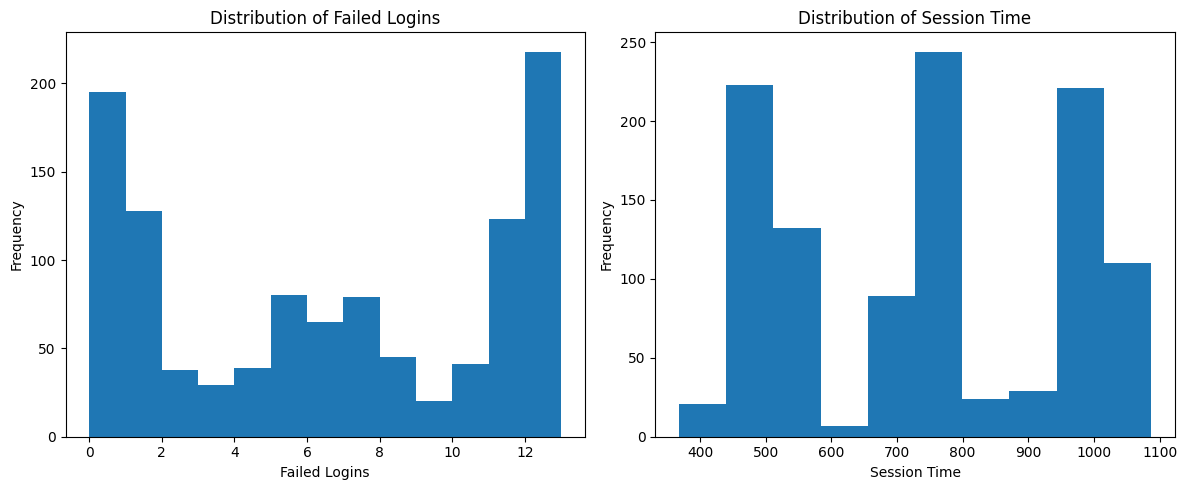

In [165]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Failed Logins Histogram
axes[0].hist(train_df['failed_logins'], bins=range(train_df['failed_logins'].min(), train_df['failed_logins'].max()+2))
axes[0].set_xlabel('Failed Logins')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Failed Logins')

# Session Time Histogram
axes[1].hist(train_df['session_time'], bins=10)
axes[1].set_xlabel('Session Time')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Session Time')

plt.tight_layout()
plt.show()

We can also plot session time vs failed login counts. It looks again like there are 3 seperable groups. 

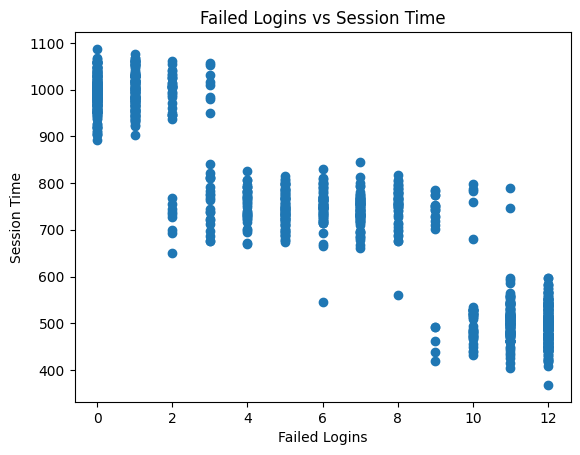

In [167]:
plt.scatter(train_df['failed_logins'], train_df['session_time'])
plt.xlabel('Failed Logins')
plt.ylabel('Session Time')
plt.title('Failed Logins vs Session Time')
plt.show()

Last, we can take a histogram of unique process call counts. This doesn't seem too informative, but it does look like a few process ids are being called significantly more than the others.

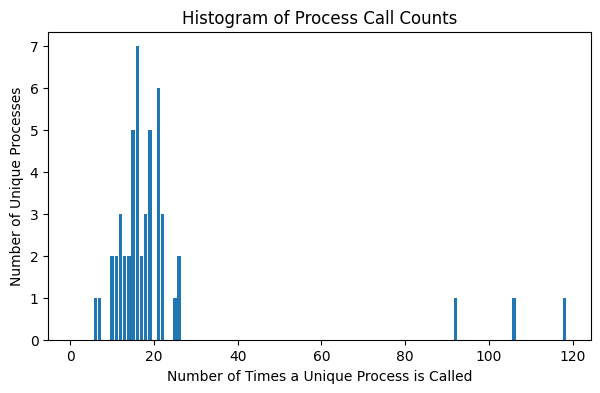

In [168]:
# Count the number of samples per user
process_counts = [extract_id(x) for x in train_df['process_id'].values.tolist()]

# Step 2: Count occurrences of each unique process number
from collections import Counter
process_counts = Counter(process_counts)

# Step 3: Plot histogram of the counts
plt.figure(figsize=(7,4))
plt.hist(list(process_counts.values()), bins=range(1, max(process_counts.values())+2), align='left', rwidth=0.8)
plt.xlabel('Number of Times a Unique Process is Called')
plt.ylabel('Number of Unique Processes')
plt.title('Histogram of Process Call Counts')
plt.show()

In [176]:
for x in [f"{k} was called {v} times." for k, v in train_df["process_id"].value_counts().to_dict().items() if v > 80]:
    print(x)

process_39 was called 118 times.
process_34 was called 106 times.
process_5 was called 92 times.


## Search Depth with Random Forest and KNN Classifiers
Ok, now that we have checked outt the data, let's see if we can throw a random forest classifier at this dataset and call it a day.

In [178]:
def train_random_forest(train_df: pd.DataFrame, test_df: pd.DataFrame) -> tuple[RandomForestClassifier, pd.DataFrame]:
    """Train a Random Forest classifier to predict user_id from behavioral features.
    
    This function trains a Random Forest model on user authentication data, including
    failed login counts, session times, and process IDs. It encodes categorical variables,
    fits the model, evaluates on test data, and returns both the trained model and
    processed test dataframe.
    
    Args:
        train_df: Training dataframe with columns ['user_id', 'failed_logins', 
                  'session_time', 'process_id']
        test_df: Test dataframe with the same schema as train_df
    
    Returns:
        tuple containing:
            - RandomForestClassifier: Trained model with 200 estimators
            - pd.DataFrame: Test dataframe with added encoded columns
    
    Note:
        Prints classification accuracy on test set to console.
    """

    df = train_df.copy()
    # ---- Encode categorical columns ----
    # Encode target
    user_encoder = LabelEncoder()
    df['user_id_encoded'] = user_encoder.fit_transform(df['user_id'])

    # Encode process_id feature
    process_encoder = LabelEncoder()
    df['process_id_encoded'] = process_encoder.fit_transform(df['process_id'])

    # ---- Prepare features and target ----
    X_train = df[['failed_logins', 'session_time', 'process_id_encoded']]
    y_train = df['user_id_encoded']

    # ---- Train Random Forest ----
    rf = RandomForestClassifier(n_estimators=200, random_state=42)
    rf.fit(X_train, y_train)

    # ------- Test Eval ______ 
    rf_test = test_df.copy()
    rf_test['process_id_encoded'] = process_encoder.transform(rf_test["process_id"])
    rf_test["user_id_encoded"] = user_encoder.transform(rf_test["user_id"])

    X_test = rf_test[['failed_logins', 'session_time', 'process_id_encoded']]
    rf_y_test = rf_test['user_id_encoded']

    y_pred = user_encoder.inverse_transform(rf.predict(X_test))

    acc = np.mean(rf_y_test == y_pred)
    print(f"Accuracy: {acc:.8f}")

    return rf, rf_test


rf_fit, rf_df = train_random_forest(train_df, test_df)

Accuracy: 0.00000000


The random forest is unable to predict any of the users correctly. This is not too surprising, as we have 300 users and are only counting a success if we get the correct user. What we are _really_ interested in are large deviations from the expected user. One metric to isolate this characteristic is search depth:
$$\text{SearchDepth}(x, y_{true}) = \left|\{y : P(y|x) \geq P(y_{true}|x)\}\right|$$

What this metric reports is the number of users required to search in until we see the correct user. This ranking methods works as an emipirical CDF over our test data. 

We'll compute this for the RF classifier and see what the plots look like. 

In [179]:
def rf_search_depth(rf_fit: RandomForestClassifier, rf_df: pd.DataFrame) -> np.ndarray:
    """Calculate search depth for Random Forest predictions.
    
    Search depth measures how many users must be searched (in order of predicted 
    probability) before finding the correct user. This provides a more nuanced 
    evaluation metric than binary accuracy for multi-class classification problems.
    
    Args:
        rf_fit: Trained RandomForestClassifier model
        rf_df: Test dataframe containing encoded features and target with columns
               ['failed_logins', 'session_time', 'process_id_encoded', 'user_id_encoded']
    
    Returns:
        Array of search depth values (rank positions) for each test sample, where
        0 means the correct user was ranked first, 1 means second, etc.
    """
    X_test = rf_df[['failed_logins', 'session_time', 'process_id_encoded']]
    y_test = rf_df['user_id_encoded']
    # get the predictive scores from the random forest.
    y_pred_proba = rf_fit.predict_proba(X_test)
    # rank the scores from largest score to lowest. 
    ranked_proba = np.argsort(-y_pred_proba, axis=1)

    # find the index of the correct user id in each row
    sd = np.argmax(ranked_proba == y_test.to_numpy()[:, None], axis=1)

    return sd

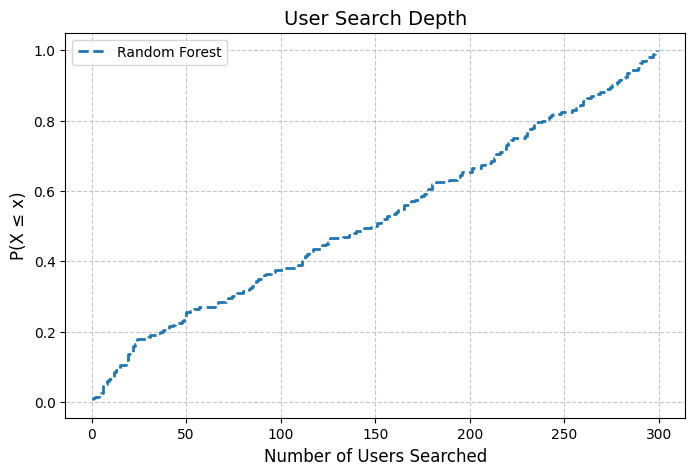

In [142]:
def plot_random_forest_search_depth(search_depth: np.ndarray) -> None:
    """Plot the cumulative distribution function (CDF) of search depths for Random Forest.
    
    Visualizes the empirical CDF showing what proportion of test samples require
    searching through N users before finding the correct match. Lower curves indicate
    better model performance, as the correct user appears earlier in the ranked list.
    
    Args:
        search_depth (np.ndarray): Array of search depth values (rank positions) for test samples
    
    Returns:
        None. Displays a matplotlib plot with search depth CDF.
    """
    # make CDF for data
    user_cdf = np.arange(1, len(search_depth) + 1) / len(search_depth) 
    # sort search_depths
    ranks = np.sort(search_depth)

    plt.figure(figsize=(8, 5))
    plt.plot(ranks, user_cdf, drawstyle="steps-post", linewidth=2, linestyle="--", label="Random Forest")

    # Labels, title, legend
    plt.xlabel("Number of Users Searched", fontsize=12)
    plt.ylabel("P(X ≤ x)", fontsize=12)
    plt.title("User Search Depth", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.show()

sd_rf = rf_search_depth(rf_fit, rf_df)
plot_random_forest_search_depth(sd_rf)

This still does not look good. The above plot tells us that 50% of the time we cut the search space in half. That is 50% of the time, the true user was contained in the top half (150) of recommended users. This is still pretty worthless. 

Maybe a K-nearest-neighbors classifier will work better? 

In [180]:
def knn_user_classifier(train_df: pd.DataFrame, test_df: pd.DataFrame, k: int) -> None:
    """Train and evaluate a K-Nearest Neighbors classifier for user identification.
    
    This function trains a KNN model on user authentication data with encoded features,
    makes predictions on test data, and prints the classification accuracy. KNN uses
    the k nearest training samples (by Euclidean distance) to predict the user class.
    
    Args:
        train_df: Training dataframe with columns ['user_id', 'failed_logins', 
                  'session_time', 'process_id']
        test_df: Test dataframe with the same schema as train_df
        k: Number of nearest neighbors to use for classification
    
    Returns:
        None. Prints prediction accuracy to console.
    """
    # Encode process_id
    process_encoder = LabelEncoder()
    train_df = train_df.copy()
    test_df = test_df.copy()
    train_df['process_id_enc'] = process_encoder.fit_transform(train_df['process_id'])
    test_df['process_id_enc'] = process_encoder.transform(test_df['process_id'])
    
    # Encode user_id (target)
    user_encoder = LabelEncoder()
    train_df['user_id_enc'] = user_encoder.fit_transform(train_df['user_id'])
    if 'user_id' in test_df.columns:
        test_df['user_id_enc'] = user_encoder.transform(test_df['user_id'])
    
    # Features and target
    X_train = train_df[['failed_logins', 'session_time', 'process_id_enc']]
    y_train = train_df['user_id_enc']
    X_test = test_df[['failed_logins', 'session_time', 'process_id_enc']]
    
    # KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    
    # Predict (returns encoded labels)
    y_pred_enc = knn.predict(X_test)
    y_pred = user_encoder.inverse_transform(y_pred_enc)
    
    accuracy = (y_pred == test_df['user_id']).mean()
    print(f"Prediction accuracy for KNN with k={k}: {accuracy:.8}")

Let's see how it performs..

In [181]:
for k in [5, 15, 25, 50, 250]:
    knn_user_classifier(train_df, test_df, k=k)

Prediction accuracy for KNN with k=5: 0.01
Prediction accuracy for KNN with k=15: 0.01
Prediction accuracy for KNN with k=25: 0.02
Prediction accuracy for KNN with k=50: 0.01
Prediction accuracy for KNN with k=250: 0.02


This is an improvement on the random forest. But again, we don't really care about the classification accuracy. We instead want to make a KNN recommendation and plot the search depth. 

In [185]:
def knn_user_classifier_with_ranking(train_df: pd.DataFrame, test_df: pd.DataFrame) -> np.ndarray:
    """Calculate search depth for KNN predictions by ranking neighbors.
    
    This function trains a KNN model with k=num_users neighbors and computes search 
    depth by finding the position of the correct user among all ranked neighbors. 
    Unlike standard KNN classification, this provides a ranking-based evaluation 
    suitable for multi-class problems with many classes.
    
    Args:
        train_df: Training dataframe with columns ['user_id', 'failed_logins', 
                  'session_time', 'process_id']
        test_df: Test dataframe with the same schema as train_df
    
    Returns:
        Array of search depth values (rank positions) for each test sample, where
        0 means the correct user was the nearest neighbor, 1 means second nearest, etc.
    """
    # Encode process_id
    process_encoder = LabelEncoder()
    train_df = train_df.copy()
    test_df = test_df.copy()
    train_df['process_id_enc'] = process_encoder.fit_transform(train_df['process_id'])
    test_df['process_id_enc'] = process_encoder.transform(test_df['process_id'])
    
    # Encode user_id (target)
    user_encoder = LabelEncoder()
    train_df['user_id_enc'] = user_encoder.fit_transform(train_df['user_id'])
    test_df['user_id_enc'] = user_encoder.transform(test_df['user_id'])
    
    # Features and target
    X_train = train_df[['failed_logins', 'session_time', 'process_id_enc']]
    y_train = train_df['user_id_enc']
    X_test = test_df[['failed_logins', 'session_time', 'process_id_enc']]
    y_test = test_df['user_id_enc']
    
    # KNN Classifier
    knn = KNeighborsClassifier(n_neighbors=num_users)
    knn.fit(X_train, y_train)
    
    y_true = user_encoder.inverse_transform(y_test)

    # Ranking index for correct label
    _, indices = knn.kneighbors(X_test)
    correct_label_positions = []
    for i, neighbor_idxs in enumerate(indices):
        # who are you closest to in the training set? 
        neighbor_user_ids = y_train.iloc[neighbor_idxs]
        # map back to original ids
        neighbor_user_ids_decoded = user_encoder.inverse_transform(neighbor_user_ids)
        # get the rank
        position = int(np.argmax(neighbor_user_ids_decoded == y_true[i]))
        correct_label_positions.append(position)
    
    ranks_knn = np.asarray(correct_label_positions, dtype=int)
    
    return ranks_knn

In [ ]:
def plot_knn_search_depth(search_depth_knn: np.ndarray, search_depth_rf: np.ndarray) -> None:
    """Plot and compare search depth CDFs for KNN and Random Forest classifiers.
    
    Visualizes the empirical cumulative distribution functions (CDFs) of search depths
    for both KNN and Random Forest models, allowing direct comparison of their ranking
    performance. Lower curves indicate better model performance.
    
    Args:
        search_depth_knn: Array of search depth values (rank positions) for KNN predictions
        search_depth_rf: Array of search depth values (rank positions) for Random Forest predictions
    
    Returns:
        None. Displays a matplotlib plot comparing both models' search depth CDFs.
    """
    # make CDF for data
    user_cdf = np.arange(1, len(search_depth_knn) + 1) / len(search_depth_knn) 
    # sort search_depths
    ranks_knn = np.sort(search_depth_knn)
    ranks_rf = np.sort(search_depth_rf)
    # Plot both CDFs
    plt.figure(figsize=(8, 5))

    plt.plot(ranks_knn, user_cdf, drawstyle="steps-post", linewidth=2, linestyle="--", label="KNN", color="orange")
    plt.plot(ranks_rf, user_cdf, drawstyle="steps-post", linewidth=2, linestyle="--", label="Random Forest", color="blue")

    # Labels, title, legend
    plt.xlabel("Number of Users Searched", fontsize=12)
    plt.ylabel("P(X ≤ x)", fontsize=12)
    plt.title("User Search Depth", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.show()

Ok now we can plot the search depth from the KNN classifier and compare it with the random forest. 

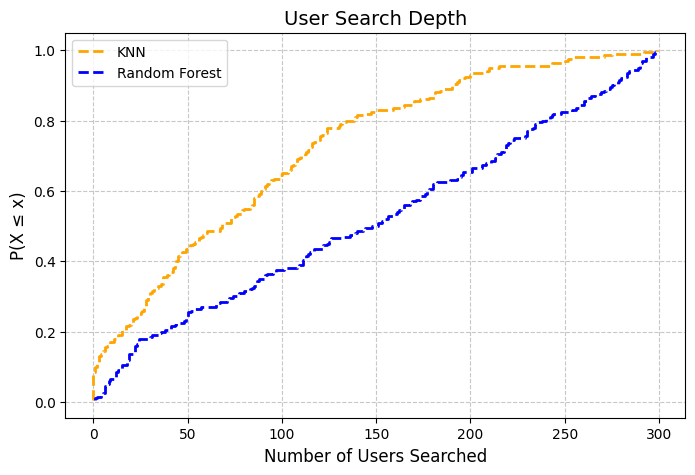

In [186]:
sd_knn = knn_user_classifier_with_ranking(train_df, test_df)
plot_knn_search_depth(sd_knn, sd_rf)

This is looking better. The KNN model places the correct user in the top 50 recommended users about ~42% of the time. It also places the correct user in the top half (150) recommended users 80% of the time. This is a pretty significant improvement. 

Since we only care about `dmx-learn` models, let's now see if we can create a model that can out perform both of these.

## Search Depth with Mixture Models

We are now going to try out a mixture model to see if we can create a better recommender. First let's revist our data so we can start picking some estimators. 

- **user_id** (str): 300 users ids of form "user_id".
- **login_failures** (int): Loging failures that are all non-negative integers.
- **session_times** (float): Non-negative floats that correspond to times. 
- **process_id** (str): 50 process ids of the form "process_id".

We will pick estimators that fit the descriptions above. To ensure our model is regularized for initialization, we will pick initial estimators and pass in sufficient statistics to ensure no user or process causes a numeric instability.

We will also go with `3` mixture components. This was chosen based on the EDA, but you are free to play with the model fitting and find your favorite model. 

In [187]:
# set the number of mixture components
num_topics = 3

# create the initial estimator for user_id
iest0 = CategoricalEstimator(suff_stat={f"user_{i}": 1.0 / num_users for i in range(num_users)}, pseudo_count=1.0e2)
# estimators for login counts and session times do not get regularized
est1 = PoissonEstimator()
est2 = GaussianEstimator()
# estimator for the process ids
iest3 = CategoricalEstimator(suff_stat={f"process_{i}": 1.0 / num_procs for i in range(num_procs)}, pseudo_count=1.0e2)

# define a composite for the tuple of size 4
iest_tuple = CompositeEstimator([iest0, est1, est2, iest3])
# define the initial mixture with num_topics components.
iest = MixtureEstimator([iest_tuple] * num_topics)

# create the estimator for user_id
est0 = CategoricalEstimator(suff_stat={f"user_{i}": 1.0 / num_users for i in range(num_users)}, pseudo_count=1.0e-16)
# create the estimator for proc id
est3 = CategoricalEstimator(suff_stat={f"process_{i}": 1.0 / num_procs for i in range(num_procs)}, pseudo_count=1.0e-16)

# estimator for the data 
est_tuple = CompositeEstimator([est0, est1, est2, est3])
est = MixtureEstimator([est_tuple] * num_topics)

We need to make sure our data is in the right format. It should be input as `list[tuple[str, int, float, str]]`. Let's make sure that is the case before we fit the data.

In [189]:
train_data = [x[1:] for x in train_df.itertuples()]
print(train_data[0])

('user_0', 12, 457, 'process_39')


Everything looks good to go. Let's make our call to optimize using our initial estimator.

In [214]:
fit = optimize(
    data=train_data,
    estimator=est,
    init_estimator=iest,
    init_p=0.10,
    rng=RandomState(2),
    max_its=10000,
    print_iter=250
)

Iteration 9: ln[p_mat(Data|Model)]=-1.761307e+04, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=2.546585e-11


Alright we have got the model fit. Recall that this model is unsupervised as specified. That is, we did not determine what our labels / targets would be apriori. Instead, we are going to pop-off components of the mixture model to create a user re-weighted mixture model that will allow us to rank the most likely user for each observed test point.

To do this, we are first going to obtain mixture weights for each of the users. Currently our model is

$$P(X) = \sum_{z} P(\text{user id} | Z) P(\text{login failures} | Z) P(\text{session time} | Z) P(\text{process id} | Z) P(Z)$$

We are going to obtain posterior weights for each user of the form:

$$P(Z=z | \text{user id}) = \frac{P(\text{user id} | Z=z) P(Z=z)}{\sum_{z} P(\text{user id} | Z=z) P(Z=z)}$$

Let's see what this looks like in `dmx-learn`. 

In [ ]:
def user_posterior_weights(model: MixtureDistribution, num_users: int) -> np.ndarray:
    """Calculate posterior mixture weights for each user from a fitted mixture model.
    
    This function extracts user-specific posterior probabilities P(Z|user_id) from a 
    trained mixture model. It creates a user-only mixture by extracting the categorical
    distribution over users from each mixture component, then computes posteriors for
    all users via Bayes' rule.
    
    Args:
        model: Fitted MixtureDistribution where first component distribution is user_id
        num_users: Total number of unique users in the dataset
    
    Returns:
        Array of shape (num_users, num_components) containing posterior probabilities
        P(Z=k|user_i) for each user i and mixture component k.
    """
    # For each mixture component, get the first entry of the composite distribution
    user_comp_dists = [comp.dists[0] for comp in model.components]
    # Pass these to a mixture with the same model weights
    user_mix_model = MixtureDistribution(components=user_comp_dists, w=model.w)

    # Data for each user
    user_data = [f"user_{i}" for i in range(num_users)]
    # encoding the data will allow us to make a vectorized call to get all posteriors at once
    user_data_encoded = seq_encode(data=user_data, model=user_mix_model)[0][1]

    # these are the user posteriors
    posteriors = user_mix_model.seq_posterior(user_data_encoded)

    return posteriors


The user posteriors should have dimension (number of users, number of mixture components). Lets verify that.

In [222]:
user_posteriors = user_posterior_weights(fit, num_users)
print(f"Shape of user_posteriors: {user_posteriors.shape}.\nMatching the number of users = {num_users} and fit.num_components={fit.num_components}.")

Shape of user_posteriors: (300, 3).
Matching the number of users = 300 and fit.num_components=3.


Great! Now we are going to make a mixture model for each user (300 in total). The mixture model will contain the fitted mixture components for the "login_failues", "session_time", and "process id". 

In [ ]:
def get_user_weighted_mixtures(model: MixtureDistribution, posteriors: np.ndarray) -> list[MixtureDistribution]:
    """Create user-specific mixture models with posterior-reweighted components.
    
    For each user, this function builds a mixture model over behavioral features 
    (excluding user_id) with mixture weights derived from the user's posterior 
    distribution P(Z|user_id). This enables user identification by comparing 
    likelihoods of observed behavior under each user's personalized mixture.
    
    Args:
        model: Fitted MixtureDistribution with CompositeDistribution components
               where first distribution is user_id
        posteriors: Array of shape (num_users, num_components) containing posterior
                    weights P(Z|user_i) from user_posterior_weights()
    
    Returns:
        List of MixtureDistribution objects, one per user, each containing the same
        mixture components (over behavioral features) but with user-specific weights.
    """

    # Make a composite mixture with the three features
    mix_comps = []
    for comp in model.components:
        # for each mixture component is a composite. Drop the first composite dist and keep the rest. 
        mix_comps.append(CompositeDistribution(comp.dists[1:]))

    # now we make a mixture for each user.
    num_users = posteriors.shape[0]
    user_mixtures = []
    for i in range(num_users):
        # every user has the same mixture components, but different weights
        user_mixtures.append(MixtureDistribution(components=mix_comps, w=posteriors[i]))

    return user_mixtures

We can print out the user mixtures and make sure they all look correct (i.e. same mixture comps for all)

In [228]:
user_mixtures = get_user_weighted_mixtures(model=fit, posteriors=user_posteriors)
print(f"user_{0}\nComponents: {user_mixtures[0].components}\nWeights: {user_mixtures[0].w}")
print(f"user_{1}\nComponents: {user_mixtures[1].components}\nWeights: {user_mixtures[1].w}")

user_0
Components: [CompositeDistribution(dists=[PoissonDistribution(0.5833333320386799, name=None, keys=None),GaussianDistribution(996.3333333773501, 1401.0666669498896, name=None, keys=None),CategoricalDistribution({'process_0': 0.008333333342033102, 'process_1': 0.008333333342033698, 'process_10': 0.008333333342033102, 'process_11': 0.011111111122710801, 'process_12': 0.002777777780797597, 'process_13': 0.011111111122708031, 'process_14': 0.005555555561355401, 'process_15': 0.02777777780677437, 'process_16': 0.02222222220913228, 'process_17': 0.011111111122643486, 'process_18': 0.016666666684066203, 'process_19': 0.01666666668406621, 'process_2': 0.013888888903388503, 'process_20': 0.013888888903388503, 'process_21': 0.002777777780677699, 'process_22': 0.03333333336813202, 'process_23': 0.027777777806776975, 'process_24': 0.019444444464744103, 'process_25': 0.005555555561561156, 'process_26': 0.011111111122710801, 'process_27': 5.555555561355401e-21, 'process_28': 0.0138888889033872

Next we can use our user-mixtures to perform a search-depth ranking on our test set. 

In [229]:
def get_mixture_search_depth(user_mixture_models: list[MixtureDistribution], test_df: pd.DataFrame) -> np.ndarray:
    """Calculate search depth for mixture model predictions by ranking log-likelihoods.
    
    For each test observation, this function computes the log-likelihood under every
    user's personalized mixture model and ranks users by descending likelihood. The
    search depth is the position where the true user appears in this ranked list.
    
    Args:
        user_mixture_models: List of MixtureDistribution objects, one per user, created
                            by get_user_weighted_mixtures()
        test_df: Test dataframe with columns ['user_id', 'failed_logins', 'session_time',
                'process_id']
    
    Returns:
        Sorted array of search depth values (rank positions) for each test sample, where
        0 means the true user had highest likelihood, 1 means second highest, etc.
    """
    # we are going to predict the user class
    test_data = [x[2:] for x in test_df.itertuples()]
    # set the labels for checking the search depth
    true_labels = [extract_id(x[1])  for x in test_df.itertuples()]
    ranks = []

    for truth, entry in zip(true_labels, test_data):
        # for each user, evaluate to log(P(X | User id))
        rv = np.asarray([m.log_density(entry) for m in user_mixture_models])
        # search depth: sort log(P(X | User id)) in descending order and fix location of correct user
        ranks.append(np.argmax(np.argsort(-rv) == truth))

    # sort the results for plotting
    ranks = np.sort(ranks)

    return ranks

Below, we can add one last function to plot the results. Let's see how the models compare. 

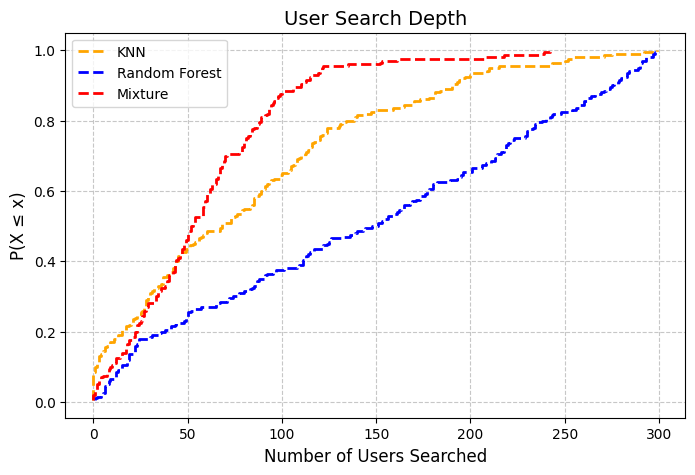

In [230]:
def plot_mixture_search_depth(search_depth_knn: np.ndarray, search_depth_rf: np.ndarray, search_depth_mix: np.ndarray) -> None:
    """Plot and compare search depth CDFs for KNN, Random Forest, and Mixture models.
    
    Visualizes the empirical cumulative distribution functions (CDFs) of search depths
    for all three models - KNN, Random Forest, and DMX Mixture - allowing comprehensive
    comparison of their ranking performance. Lower curves indicate better model performance,
    demonstrating how quickly each model identifies the correct user.
    
    Args:
        search_depth_knn: Array of search depth values (rank positions) for KNN predictions
        search_depth_rf: Array of search depth values (rank positions) for Random Forest predictions
        search_depth_mix: Array of search depth values (rank positions) for Mixture model predictions
    
    Returns:
        None. Displays a matplotlib plot comparing all three models' search depth CDFs.
    """
    # make CDF for data
    user_cdf = np.arange(1, len(search_depth_knn) + 1) / len(search_depth_knn) 
    # sort search_depths
    ranks_knn = np.sort(search_depth_knn)
    ranks_rf = np.sort(search_depth_rf)
    ranks_mix = np.sort(search_depth_mix)
    # Plot both CDFs
    plt.figure(figsize=(8, 5))

    plt.plot(ranks_knn, user_cdf, drawstyle="steps-post", linewidth=2, linestyle="--", label="KNN", color="orange")
    plt.plot(ranks_rf, user_cdf, drawstyle="steps-post", linewidth=2, linestyle="--", label="Random Forest", color="blue")
    plt.plot(ranks_mix, user_cdf, drawstyle="steps-post", linewidth=2, linestyle="--", label="Mixture", color="red")
    # Labels, title, legend
    plt.xlabel("Number of Users Searched", fontsize=12)
    plt.ylabel("P(X ≤ x)", fontsize=12)
    plt.title("User Search Depth", fontsize=14)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.7)

    plt.show()

sd_mix = get_mixture_search_depth(user_mixture_models=user_mixtures, test_df=test_df)
plot_mixture_search_depth(sd_knn, sd_rf, sd_mix)

It looks like search-depth with user re-weighted mixture models out performs the KNN classifier. This model places the correct user in the top 100 ~90% of the time, up from ~65% with the KNN classifier. 

## Summary

### Why Search Depth Matters

Traditional machine learning classifiers (Random Forest, KNN) often struggle with:
- **Imbalanced data**: Some users have very few samples
- **Multi-modal behavior**: Users may exhibit different behavioral patterns
- **Uncertainty quantification**: Hard classifications don't capture behavioral overlap

Poor search depth leads to:
- ❌ Increased investigation time
- ❌ False positives overwhelming security teams  
- ❌ Delayed threat response

### How DMX-Learn Helps

`dmx-learn` uses **probabilistic mixture models** to:
- ✅ Model complex, multi-modal user behaviors
- ✅ Provide uncertainty-aware predictions
- ✅ Handle sparse data with proper regularization
- ✅ Capture latent behavioral topics across users

To make this example for difficult, you may ask what would happen if instead the `process_id` variable contained a sequence of process calls? How could the random forest or KNN method possibly work in this case. We will investigate models such as the `SequenceEstimator` and `HiddenMarkovModel` to handle sequences of varying length for search-depth like problems in `dmx-learn` in a more advanced noteboook. 